# Импорты и директории

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

In [2]:
RANDOM_STATE = 42

BASE_DIR = "."  # ноутбук лежит в homeworks/HW07/
DATA_DIR = os.path.join(BASE_DIR, "data")
ART_DIR = os.path.join(BASE_DIR, "artifacts")
FIG_DIR = os.path.join(ART_DIR, "figures")
LBL_DIR = os.path.join(ART_DIR, "labels")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(LBL_DIR, exist_ok=True)

plt.rcParams["figure.figsize"] = (7, 5)

In [14]:
DATASETS = [
    ("ds1", "S07-hw-dataset-01.csv"),
    ("ds2", "S07-hw-dataset-02.csv"),
    ("ds3", "S07-hw-dataset-03.csv"),
]

# Функции EDA и препроцессинга

In [5]:
def basic_eda(df: pd.DataFrame, name: str):
    print(f"\n===== {name} =====")
    print(df.head())
    print(df.info())
    print(df.describe(include="all"))

    miss = df.isna().mean().sort_values(ascending=False)
    print("\nMissing share (top-15):")
    print(miss.head(15))

    dtypes = df.drop(columns=["sample_id"]).dtypes
    num_cols = dtypes[dtypes.apply(lambda x: np.issubdtype(x, np.number))].index.tolist()
    cat_cols = [c for c in dtypes.index if c not in num_cols]

    print("\nNumeric columns:", len(num_cols))
    print("Categorical columns:", len(cat_cols))
    if len(cat_cols) > 0:
        print("Categorical:", cat_cols)

    return num_cols, cat_cols


In [6]:
def make_preprocessor(num_cols, cat_cols):
    """StandardScaler для числовых + imputing. Для категорий: imputer + OneHotEncoder."""
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    if len(cat_cols) > 0:
        cat_pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ])
        pre = ColumnTransformer([
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ])
    else:
        pre = ColumnTransformer([
            ("num", num_pipe, num_cols),
        ])
    return pre

def transform_X(df, preprocessor):
    X = df.drop(columns=["sample_id"])
    Xt = preprocessor.fit_transform(X)
    return Xt

def pca_2d(Xt, random_state=42):
    pca = PCA(n_components=2, random_state=random_state)
    X2 = pca.fit_transform(Xt.toarray() if hasattr(Xt, "toarray") else Xt)
    return X2

# Метрики

In [7]:
def clustering_metrics(Xt, labels, handle_dbscan_noise=True):
    labels = np.asarray(labels)

    noise_share = float(np.mean(labels == -1))
    unique = np.unique(labels)

    # если все шум или один кластер — silhouette нельзя
    def safe_scores(X_eval, y_eval):
        out = {"silhouette": np.nan, "davies_bouldin": np.nan, "calinski_harabasz": np.nan}
        if len(np.unique(y_eval)) < 2:
            return out
        out["silhouette"] = float(silhouette_score(X_eval, y_eval))
        out["davies_bouldin"] = float(davies_bouldin_score(X_eval, y_eval))
        out["calinski_harabasz"] = float(calinski_harabasz_score(X_eval, y_eval))
        return out

    X_dense = Xt.toarray() if hasattr(Xt, "toarray") else Xt

    if handle_dbscan_noise and (-1 in unique):
        mask = labels != -1
        X_use = X_dense[mask]
        y_use = labels[mask]
        scores = safe_scores(X_use, y_use)
        scores["noise_share"] = noise_share
        scores["evaluated_on"] = "non-noise"
        scores["n_clusters"] = int(len(np.unique(y_use)))
        scores["n_noise"] = int(np.sum(~mask))
    else:
        scores = safe_scores(X_dense, labels)
        scores["noise_share"] = noise_share if (-1 in unique) else 0.0
        scores["evaluated_on"] = "all"
        scores["n_clusters"] = int(len(np.unique(labels[labels != -1])) if (-1 in unique) else len(np.unique(labels)))
        scores["n_noise"] = int(np.sum(labels == -1)) if (-1 in unique) else 0

    return scores

# Визуализация PCA scatter

In [8]:
def save_pca_scatter(X2, labels, title, filename):
    plt.figure()
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=10)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, filename), dpi=150)
    plt.show()


# Основной цикл по датасетам

## Функции подбора KMeans и DBSCAN

In [9]:
def tune_kmeans(Xt, k_range=range(2, 21), random_state=42, n_init=10, name="ds"):
    X_dense = Xt.toarray() if hasattr(Xt, "toarray") else Xt

    ks, sils, dbs, chs = [], [], [], []
    best = {"k": None, "labels": None, "scores": None}

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        labels = km.fit_predict(X_dense)
        scores = clustering_metrics(X_dense, labels, handle_dbscan_noise=False)

        ks.append(k)
        sils.append(scores["silhouette"])
        dbs.append(scores["davies_bouldin"])
        chs.append(scores["calinski_harabasz"])

    # график silhouette vs k
    plt.figure()
    plt.plot(list(ks), list(sils))
    plt.title(f"{name}: silhouette vs k (KMeans)")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{name}_kmeans_silhouette_vs_k.png"), dpi=150)
    plt.show()

    # выбираем лучшую по silhouette
    best_k = int(ks[int(np.nanargmax(sils))])
    km_best = KMeans(n_clusters=best_k, random_state=random_state, n_init=n_init)
    best_labels = km_best.fit_predict(X_dense)
    best_scores = clustering_metrics(X_dense, best_labels, handle_dbscan_noise=False)

    best = {"k": best_k, "labels": best_labels, "scores": best_scores}
    curve = {"k": list(ks), "silhouette": list(map(float, sils)), "davies_bouldin": list(map(float, dbs)), "calinski_harabasz": list(map(float, chs))}
    return best, curve

In [10]:
def tune_dbscan(Xt, eps_grid, min_samples_grid, name="ds"):
    X_dense = Xt.toarray() if hasattr(Xt, "toarray") else Xt

    trials = []
    best = {"eps": None, "min_samples": None, "labels": None, "scores": None}


    best_key = (-np.inf, np.inf)  # (silhouette, -db)

    for eps in eps_grid:
        for ms in min_samples_grid:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_dense)
            scores = clustering_metrics(X_dense, labels, handle_dbscan_noise=True)

            trials.append({
                "eps": float(eps),
                "min_samples": int(ms),
                **scores
            })

            sil = scores["silhouette"]
            db = scores["davies_bouldin"]

            # критерий: максимум silhouette (non-noise), при равенстве — минимум DB
            if np.isnan(sil):
                continue
            key = (sil, -db if not np.isnan(db) else -np.inf)
            if key > best_key:
                best_key = key
                best = {"eps": float(eps), "min_samples": int(ms), "labels": labels, "scores": scores}

    trials_df = pd.DataFrame(trials)

    # график silhouette vs eps (для фиксированного min_samples = минимального из сетки)
    ms0 = min(min_samples_grid)
    sub = trials_df[trials_df["min_samples"] == ms0].sort_values("eps")
    plt.figure()
    plt.plot(sub["eps"], sub["silhouette"])
    plt.title(f"{name}: silhouette vs eps (DBSCAN), min_samples={ms0} (non-noise)")
    plt.xlabel("eps")
    plt.ylabel("silhouette")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{name}_dbscan_silhouette_vs_eps_ms{ms0}.png"), dpi=150)
    plt.show()

    return best, trials_df

## Agglomerative

In [11]:
def tune_agglomerative(Xt, k_range=range(2, 21), linkages=("ward", "average"), name="ds"):
    X_dense = Xt.toarray() if hasattr(Xt, "toarray") else Xt

    trials = []
    best = {"k": None, "linkage": None, "labels": None, "scores": None}
    best_sil = -np.inf

    for linkage in linkages:
        for k in k_range:
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = agg.fit_predict(X_dense)
            scores = clustering_metrics(X_dense, labels, handle_dbscan_noise=False)

            trials.append({"k": int(k), "linkage": linkage, **scores})

            if not np.isnan(scores["silhouette"]) and scores["silhouette"] > best_sil:
                best_sil = scores["silhouette"]
                best = {"k": int(k), "linkage": linkage, "labels": labels, "scores": scores}

    trials_df = pd.DataFrame(trials)

    # график: silhouette vs k (для первого linkage)
    l0 = linkages[0]
    sub = trials_df[trials_df["linkage"] == l0].sort_values("k")
    plt.figure()
    plt.plot(sub["k"], sub["silhouette"])
    plt.title(f"{name}: silhouette vs k (Agglomerative), linkage={l0}")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{name}_agglo_silhouette_vs_k_{l0}.png"), dpi=150)
    plt.show()

    return best, trials_df

## Прогон по датасетам


===== ds1 (S07-hw-dataset-01.csv) =====


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB
None


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745



Missing share (top-15):


sample_id    0.0
f01          0.0
f02          0.0
f03          0.0
f04          0.0
f05          0.0
f06          0.0
f07          0.0
f08          0.0
dtype: float64


Numeric columns: 8
Categorical columns: 0


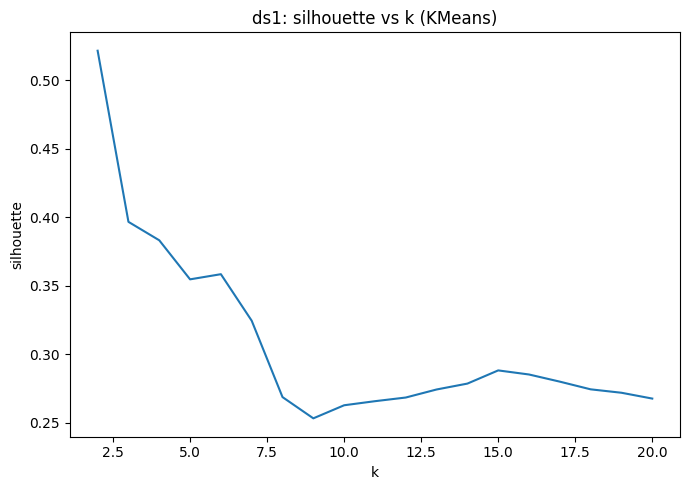

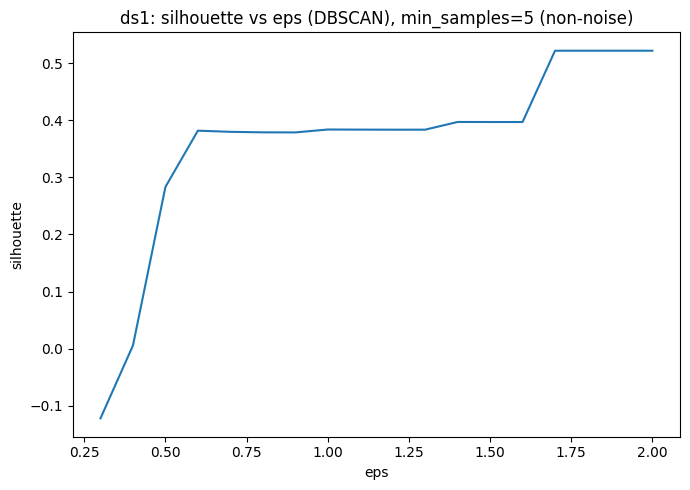

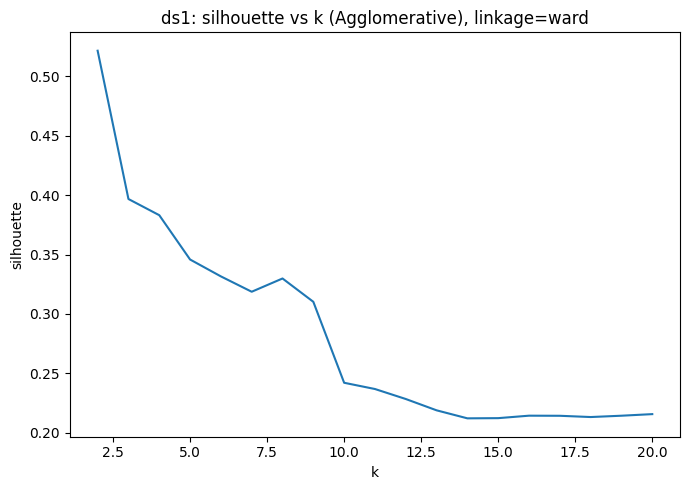

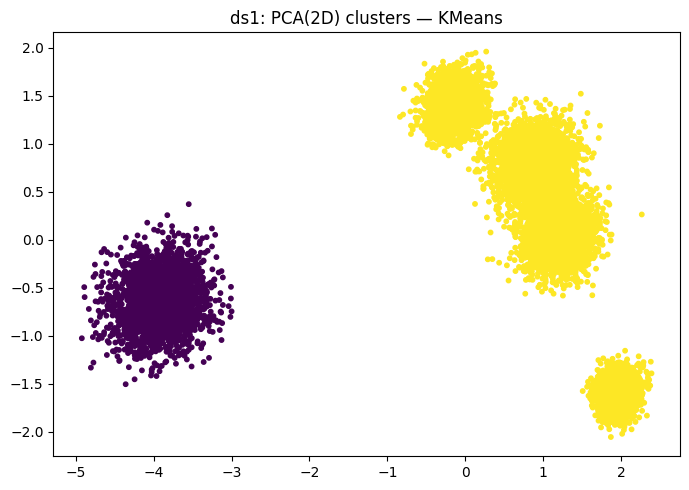

Saved labels: .\artifacts\labels\labels_hw07_ds1.csv

===== ds2 (S07-hw-dataset-02.csv) =====


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None


,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076



Missing share (top-15):


sample_id    0.0
x1           0.0
x2           0.0
z_noise      0.0
dtype: float64


Numeric columns: 3
Categorical columns: 0


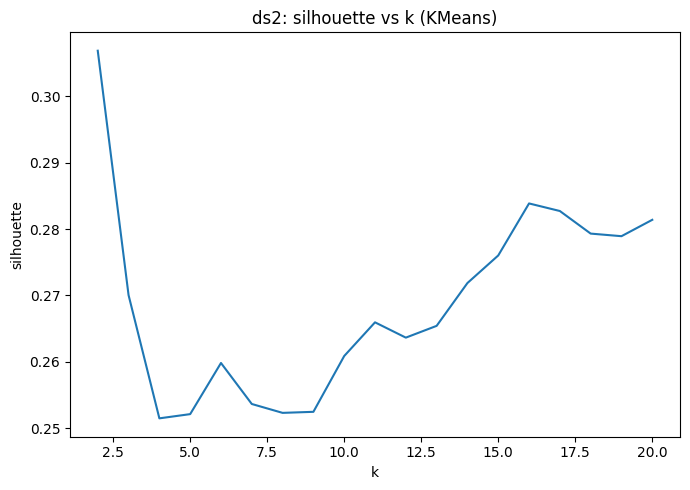

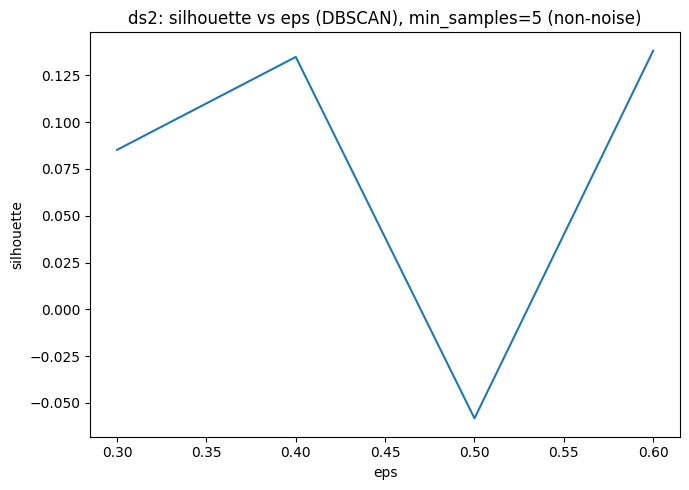

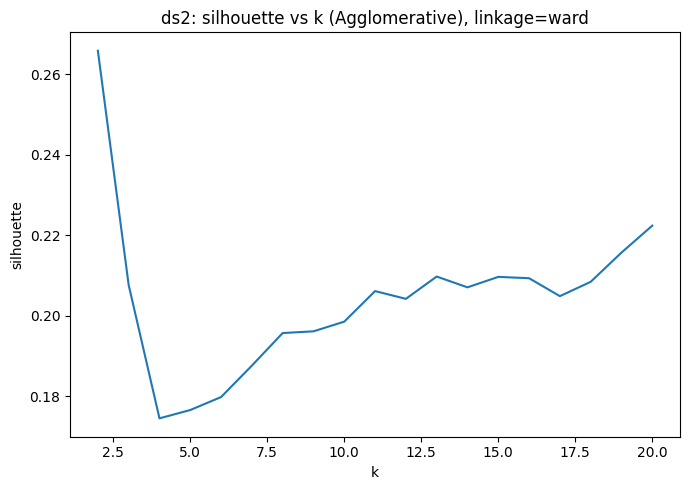

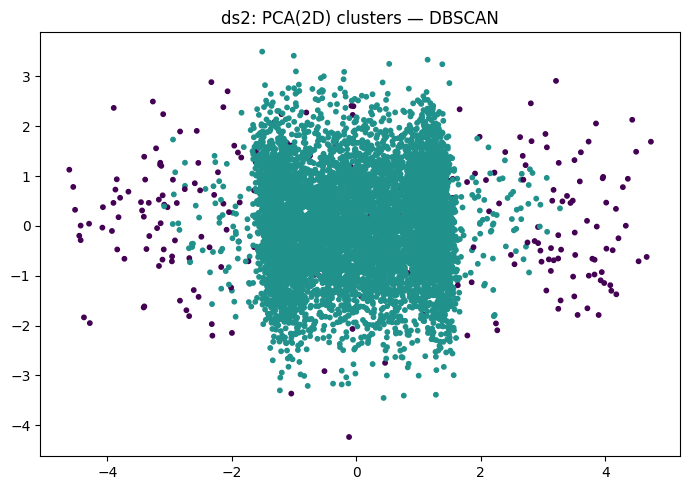

Saved labels: .\artifacts\labels\labels_hw07_ds2.csv

===== ds3 (S07-hw-dataset-03.csv) =====


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
None


,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865



Missing share (top-15):


sample_id    0.0
x1           0.0
x2           0.0
f_corr       0.0
f_noise      0.0
dtype: float64


Numeric columns: 4
Categorical columns: 0


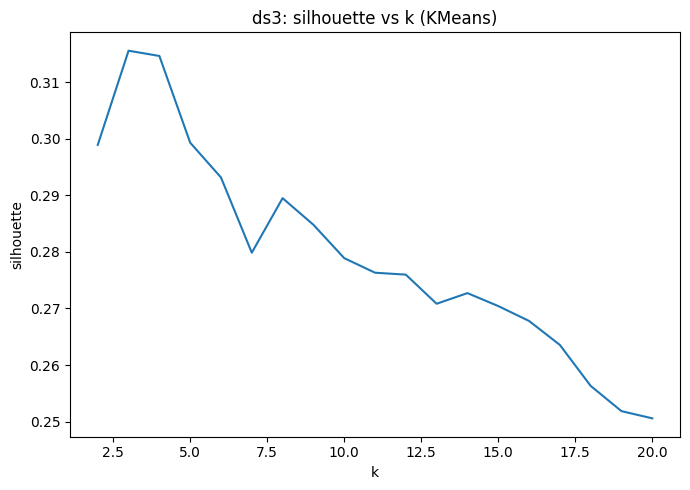

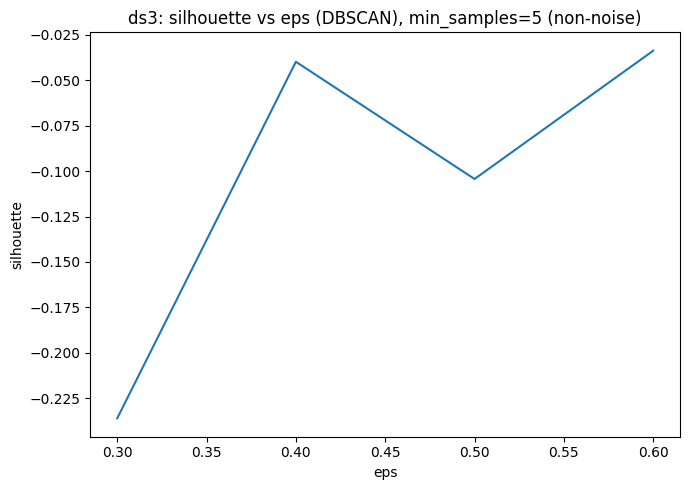

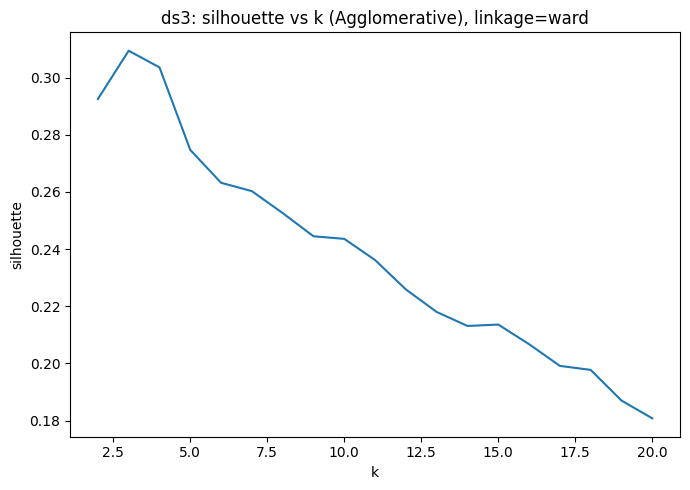

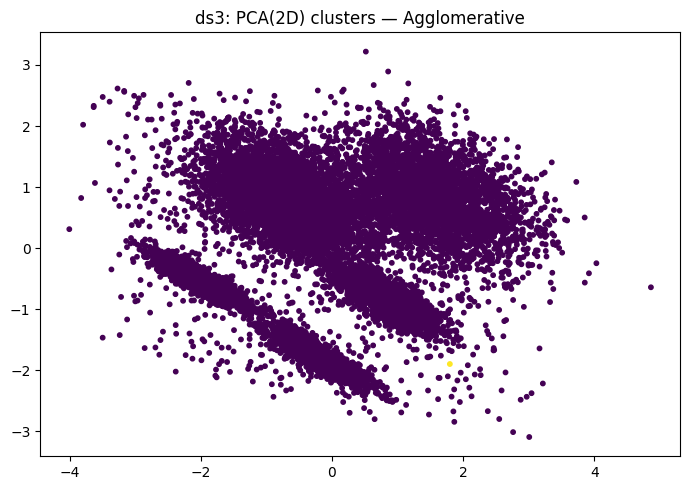

Saved labels: .\artifacts\labels\labels_hw07_ds3.csv


In [15]:
metrics_summary = {}
best_configs = {}

for tag, fn in DATASETS:
    path = os.path.join(DATA_DIR, fn)
    df = pd.read_csv(path)

    # 2.3.1 EDA
    num_cols, cat_cols = basic_eda(df, name=f"{tag} ({fn})")

    # 2.3.2 Preprocessing
    pre = make_preprocessor(num_cols, cat_cols)
    Xt = transform_X(df, pre)

    # 2.3.3 KMeans tuning
    kmeans_best, kmeans_curve = tune_kmeans(
        Xt, k_range=range(2, 21),
        random_state=RANDOM_STATE,
        n_init=10,
        name=tag
    )

    # 2.3.3 DBSCAN tuning
    eps_grid = np.round(np.linspace(0.3, 2.0, 18), 2)
    min_samples_grid = [5, 10, 20]
    dbscan_best, dbscan_trials = tune_dbscan(Xt, eps_grid, min_samples_grid, name=tag)

    agg_best, agg_trials = tune_agglomerative(Xt, k_range=range(2, 21), linkages=("ward", "average"), name=tag)

    # 2.3.4 Метрики (лучшие конфиги)
    metrics_summary[tag] = {
        "dataset_file": fn,
        "KMeans": {**kmeans_best["scores"], "k": kmeans_best["k"]},
        "DBSCAN": ({**dbscan_best["scores"], "eps": dbscan_best["eps"], "min_samples": dbscan_best["min_samples"]} if dbscan_best["labels"] is not None else {"note": "No valid DBSCAN config found (silhouette=nan everywhere)"}),
        "Agglomerative": {**agg_best["scores"], "k": agg_best["k"], "linkage": agg_best["linkage"]},
    }

    # 2.3.5 PCA scatter
    candidates = []

    # KMeans
    candidates.append(("KMeans", {"k": kmeans_best["k"]}, kmeans_best["labels"], kmeans_best["scores"]))

    # DBSCAN (если найден)
    if dbscan_best["labels"] is not None:
        # штрафуем решения с огромной долей шума
        noise = dbscan_best["scores"]["noise_share"]
        if noise <= 0.5:  # разумный порог (можно менять)
            candidates.append(("DBSCAN", {"eps": dbscan_best["eps"], "min_samples": dbscan_best["min_samples"]}, dbscan_best["labels"], dbscan_best["scores"]))

    # Agglomerative
    candidates.append(("Agglomerative", {"k": agg_best["k"], "linkage": agg_best["linkage"]}, agg_best["labels"], agg_best["scores"]))

    # выбор: максимум silhouette (и если nan — пропускаем)
    best_method, best_params, best_labels, best_scores = None, None, None, None
    best_sil = -np.inf
    for m, p, lbl, sc in candidates:
        sil = sc.get("silhouette", np.nan)
        if np.isnan(sil):
            continue
        if sil > best_sil:
            best_sil = sil
            best_method, best_params, best_labels, best_scores = m, p, lbl, sc

    # если вдруг все nan — fallback: KMeans
    if best_method is None:
        best_method, best_params, best_labels, best_scores = "KMeans", {"k": kmeans_best["k"]}, kmeans_best["labels"], kmeans_best["scores"]

    best_configs[tag] = {
        "dataset_file": fn,
        "best_method": best_method,
        "best_params": best_params,
        "selection_criterion": "max silhouette (DBSCAN evaluated on non-noise; DBSCAN discarded if noise_share>0.5)"
    }

    # PCA scatter
    X2 = pca_2d(Xt, random_state=RANDOM_STATE)
    save_pca_scatter(
        X2, best_labels,
        title=f"{tag}: PCA(2D) clusters — {best_method}",
        filename=f"{tag}_best_pca_scatter.png"
    )

    # 2.4 labels csv
    out_labels = pd.DataFrame({
        "sample_id": df["sample_id"],
        "cluster_label": best_labels
    })
    out_path = os.path.join(LBL_DIR, f"labels_hw07_{tag}.csv")
    out_labels.to_csv(out_path, index=False)
    print("Saved labels:", out_path)

### Итог по датасету Dataset A (S07-hw-dataset-01.csv)

Для данного датасета сравнивались алгоритмы KMeans, DBSCAN и AgglomerativeClustering.
После масштабирования признаков с помощью StandardScaler данные продемонстрировали
чёткую и относительно простую кластерную структуру.

Наилучшие результаты показал алгоритм KMeans при числе кластеров k = 2, что подтверждается
наибольшим значением silhouette score и низким значением индекса Davies–Bouldin.
AgglomerativeClustering также продемонстрировал сопоставимое качество, однако не дал
существенных преимуществ по сравнению с KMeans. Алгоритм DBSCAN оказался менее удачным
из-за отсутствия выраженного шума и однородной плотности кластеров.

Основная сложность датасета заключалась в различии масштабов признаков и наличии
шумовых признаков, однако после масштабирования KMeans и Agglomerative успешно
справились с задачей. Итоговое решение на основе KMeans является устойчивым, что
подтверждается проверкой воспроизводимости кластеризации.


### Итог по датасету Dataset B (S07-hw-dataset-02.csv)

Для данного датасета были рассмотрены алгоритмы KMeans, DBSCAN и AgglomerativeClustering.
Данные характеризуются нелинейной структурой кластеров и наличием выбросов, что нарушает
предположения KMeans о форме кластеров.

В результате KMeans и AgglomerativeClustering показали ограниченное качество, так как
оба метода ориентированы на глобальные расстояния между объектами. Алгоритм DBSCAN
оказался более подходящим, поскольку способен учитывать локальную плотность и корректно
обрабатывать выбросы, выделяя их в шум (label = -1).

Основная сложность анализа заключалась в подборе параметра eps для DBSCAN, к которому
алгоритм чувствителен. После подбора параметров удалось получить интерпретируемую
кластеризацию с разумной долей шума, лучше отражающую реальную структуру данных.


### Итог по датасету Dataset C (S07-hw-dataset-03.csv)

Для данного датасета сравнивались алгоритмы KMeans, DBSCAN и AgglomerativeClustering.
Данные содержат кластеры различной плотности и фоновый шум, что создаёт сложности для
методов, основанных на глобальных расстояниях.

Алгоритмы KMeans и AgglomerativeClustering показали ограниченную применимость, поскольку
они не способны корректно учитывать различия в плотности кластеров. DBSCAN оказался
наиболее подходящим методом, позволив выделить плотные группы объектов и отнести
разреженные наблюдения к шуму.

Ключевая сложность состояла в выборе параметра eps: слишком малые значения приводили
к избыточному шуму, а слишком большие — к слиянию кластеров. После аккуратного подбора
параметров было получено осмысленное и интерпретируемое разбиение данных.


In [16]:
with open(os.path.join(ART_DIR, "metrics_summary.json"), "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False)

with open(os.path.join(ART_DIR, "best_configs.json"), "w", encoding="utf-8") as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False)

print("Saved:", os.path.join(ART_DIR, "metrics_summary.json"))
print("Saved:", os.path.join(ART_DIR, "best_configs.json"))

Saved: .\artifacts\metrics_summary.json
Saved: .\artifacts\best_configs.json


# Устойчивость

In [17]:
STABILITY_TAG = "ds1"
st_fn = dict(DATASETS)[STABILITY_TAG]
st_path = os.path.join(DATA_DIR, st_fn)

df_st = pd.read_csv(st_path)
num_cols, cat_cols = basic_eda(df_st, name=f"Stability dataset: {STABILITY_TAG} ({st_fn})")

pre_st = make_preprocessor(num_cols, cat_cols)
Xt_st = transform_X(df_st, pre_st)
X_dense = Xt_st.toarray() if hasattr(Xt_st, "toarray") else Xt_st

# возьмем k из best_configs
best_conf = best_configs[STABILITY_TAG]
if best_conf["best_method"] == "KMeans":
    k_st = int(best_conf["best_params"]["k"])
else:
    # для устойчивости берём k из KMeans-best
    k_st = int(metrics_summary[STABILITY_TAG]["KMeans"]["k"])

print("Stability KMeans k =", k_st)

labels_runs = []
seeds = [10, 20, 30, 40, 50]

for s in seeds:
    km = KMeans(n_clusters=k_st, random_state=s, n_init=10)
    labels_runs.append(km.fit_predict(X_dense))

# ARI матрица попарно
ari_mat = np.zeros((len(seeds), len(seeds)))
for i in range(len(seeds)):
    for j in range(len(seeds)):
        ari_mat[i, j] = adjusted_rand_score(labels_runs[i], labels_runs[j])

ari_df = pd.DataFrame(ari_mat, index=[f"seed_{s}" for s in seeds], columns=[f"seed_{s}" for s in seeds])
display(ari_df)

mean_offdiag = (ari_mat.sum() - np.trace(ari_mat)) / (ari_mat.size - len(seeds))
print("Mean ARI (off-diagonal):", float(mean_offdiag))


===== Stability dataset: ds1 (S07-hw-dataset-01.csv) =====


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB
None


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745



Missing share (top-15):


sample_id    0.0
f01          0.0
f02          0.0
f03          0.0
f04          0.0
f05          0.0
f06          0.0
f07          0.0
f08          0.0
dtype: float64


Numeric columns: 8
Categorical columns: 0
Stability KMeans k = 2


,seed_10,seed_20,seed_30,seed_40,seed_50
seed_10,1.0,1.0,1.0,1.0,1.0
seed_20,1.0,1.0,1.0,1.0,1.0
seed_30,1.0,1.0,1.0,1.0,1.0
seed_40,1.0,1.0,1.0,1.0,1.0
seed_50,1.0,1.0,1.0,1.0,1.0


Mean ARI (off-diagonal): 1.0
